# AI/LLM for Devs, Week 1 Experiment notebook

This notebook captures a series of experiments to understand and explore working with neural networks.

The initial starting demo was fine-tuning the resnet18 model to recognize bird images, [notebook here](https://colab.research.google.com/drive/11mfy0oWj9IUgZuU3fhcOxV5iwfVEeonK#scrollTo=49pQQPyn4TbA).

## Background

Before warming up to the experiments, confirm your high level understanding of neural networks by answering the following questions below. Write your answers in this notebook.

1. What is the difference between classification and regression?

Answer: Classification is a prediction problem whose outputs are categorical. On the other hand, while Regression is also a prediction problem, the outputs are continuous. E.g., predicting housing prices is a regression problem while predicting if an animal is a cat or dog is a classification problem.

2. Describe how a feedforward model architecture works, using terms like neurons, input/hidden/output layers, weight/biases, and activation functions.


3. Besides feedforward architectures, what are the other common architectures, and when are they used?


4. Describe how the training loop works using terms like weights, backpropagation (using stochastic gradient descent), loss functions, batches, and epochs.

5. How is fine tuning different from training?

Answer: Fine tuning is a process of re-training a pretrained model with specific training data to solve the problem at hand.

6. What is overfitting, and what are various causes of it?

Answer: When the error for training set is very low compared to error for validation set, the model is said to have high variance aka overfitting. Some of the reasons could be lack of enough training data.


7. What is the difference between parameters and hyperparameters?

Answer: Weights and biases are parameters. Parameters that you can control such as learning rate, # hidden layers, # hidden units in each layer, choice of activation function, batch size, epoch size, regularization, momentum etc. are hyperparameters.

8. What are the most important hyperparameters?

Answer: Learning rate, batch size, choice of activation function, regularization.

If you have a firm grasp of the concepts above, it covers most of the basics that you'll need later.


## Setup

It's common to store training files in your Google Drive. In order to run the setup code below, you need to copy the training images into a folder called `bird_or_not` in your Google Drive. Download the files [here](https://drive.google.com/drive/folders/1uvs9iDljZHSiP0WuGyAP9j962n8N50Mz?usp=drive_link), then run the cells below.

In [3]:
# from google.colab import drive
from pathlib import Path

# Mount Google Drive
# drive.mount('/content/drive')

In [2]:
# Setup

# !pip install fastai
# !pip install fastbook

from fastbook import *
from fastai.vision.widgets import *

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/praneethyerrapragada/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.061365,0.993461,0.281250,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.305429,0.453833,0.125000,00:01
1,0.184205,0.166219,0.093750,00:00
2,0.148126,0.079953,0.031250,00:00


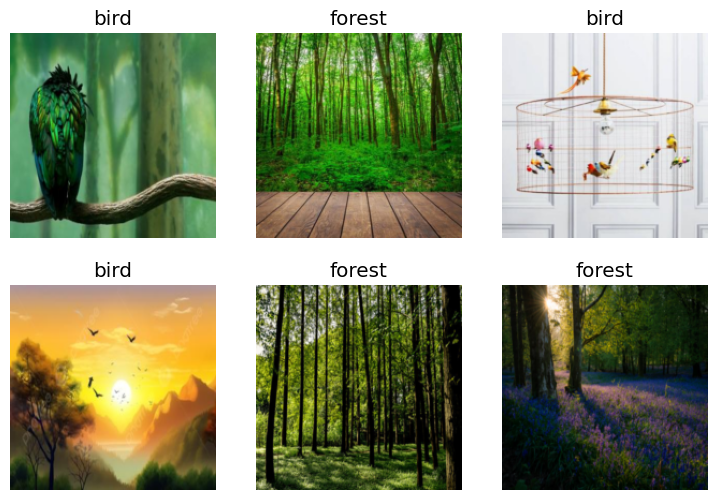

In [4]:
path = Path('../data/bird_or_not')

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Experiment #1 - Add an additional class

The initial project has just two classes: birds and forests. Add a third class (e.g., cats or anything else you want), and manually test the classifier by passing in a few selected images of cats, birds, or forests.

epoch,train_loss,valid_loss,error_rate,time
0,1.190302,0.132035,0.039568,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.366266,0.036871,0.007194,00:07
1,0.243800,0.038947,0.007194,00:07
2,0.167987,0.016536,0.007194,00:07


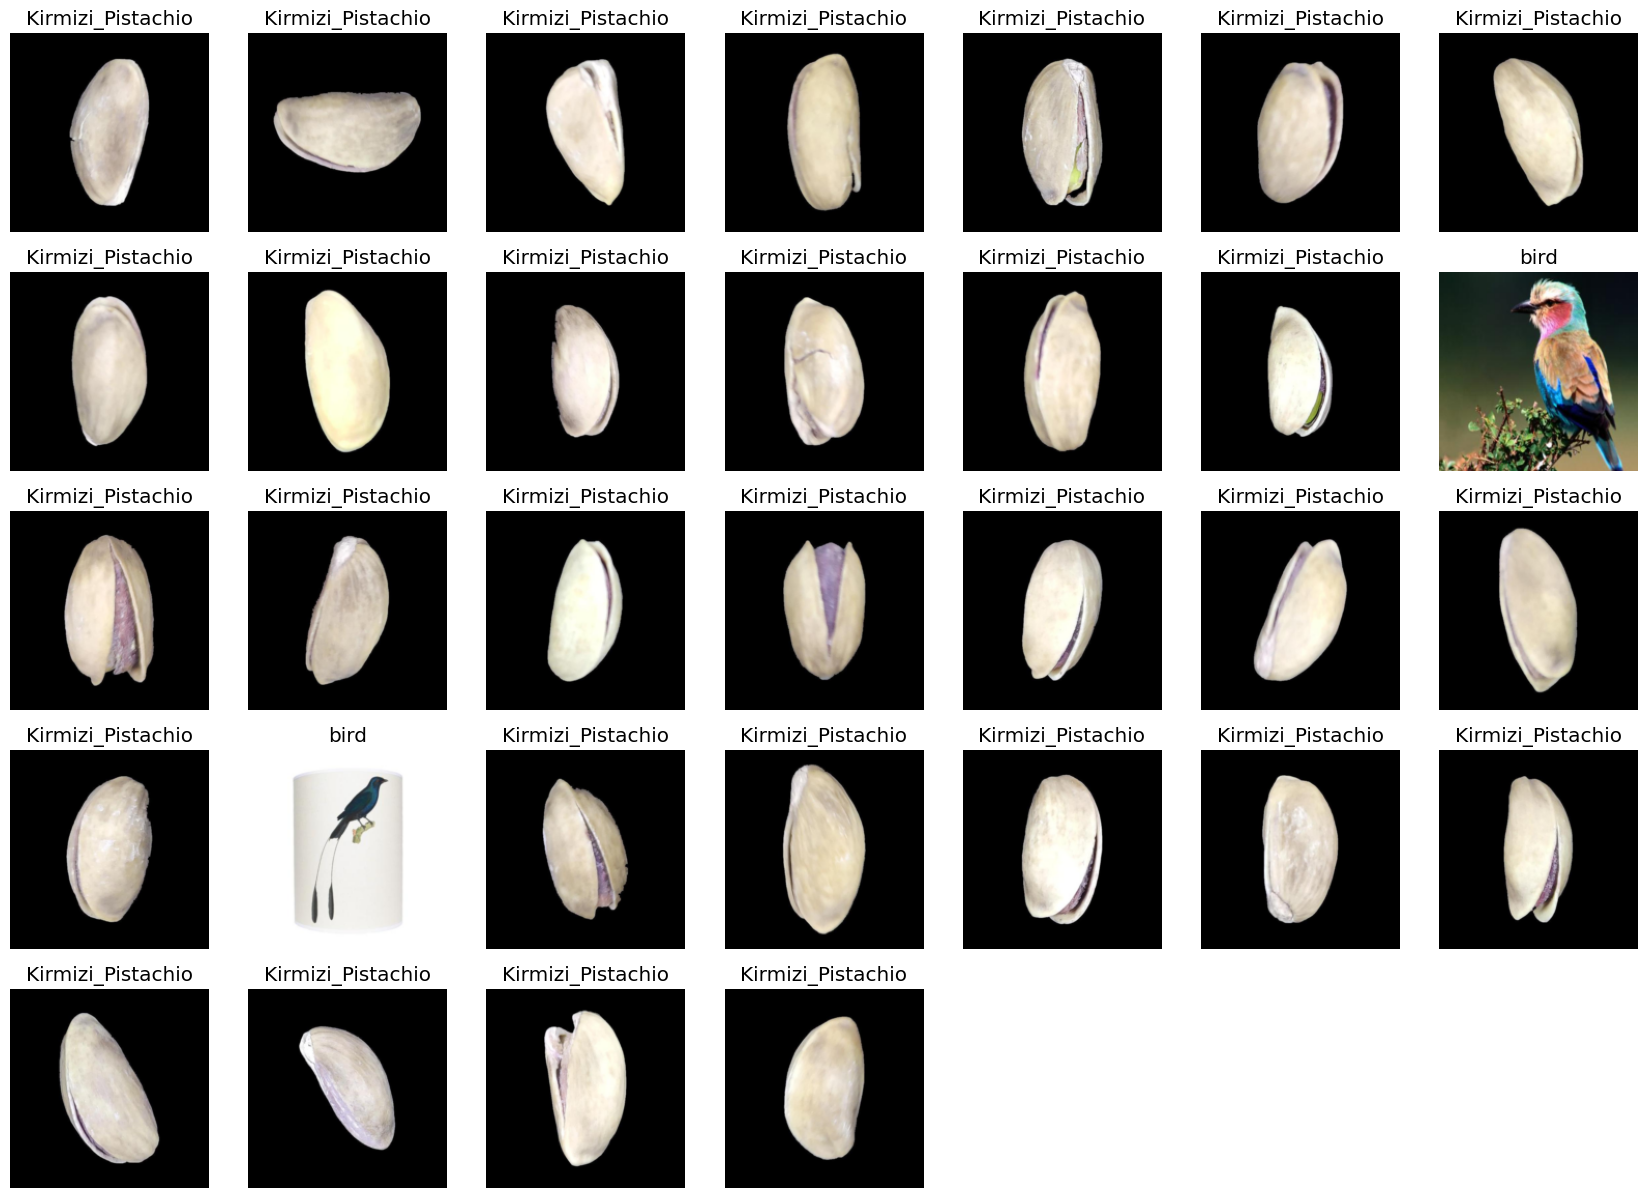

In [12]:
# Experiment #1 code
path = Path('../data')

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=64)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(32)


epoch,train_loss,valid_loss,error_rate,time
0,1.151219,0.159808,0.039568,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.297893,0.062113,0.017986,00:07
1,0.215810,0.048701,0.003597,00:07
2,0.215635,0.041967,0.007194,00:07
3,0.144305,0.051944,0.003597,00:07
4,0.131065,0.029131,0.003597,00:07
5,0.085742,0.053881,0.003597,00:07
6,0.148436,0.154550,0.010791,00:07
7,0.106250,0.057394,0.003597,00:07
8,0.064572,0.133608,0.010791,00:07
9,0.138299,0.117736,0.003597,00:07


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

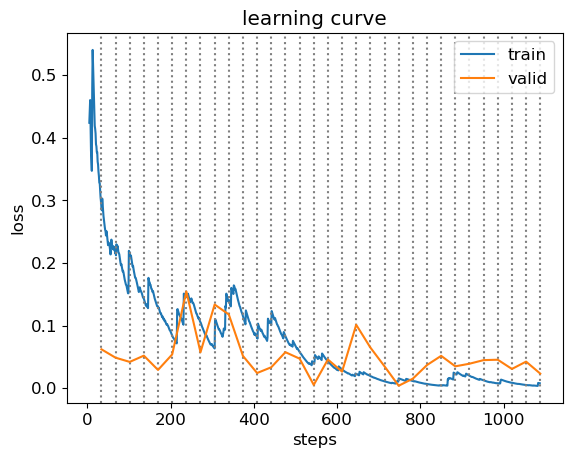

In [21]:
learn.recorder.plot_loss(show_epochs=True)

# Experiment #1 observations
1. Given that the training loss is very high compared to the validation loss, the model is underfitting.
2. One approch to mitigate underfitting is to train the network longer. This can be done by increasing the number of epochs.
3. Increasing the number of epochs can lead to overfitting. Experimenting with different epochs to see where the model converges.
4. From the plot above, it is clear that the model starts to converge at around 18 epochs i.e. around the point where the validation loss is close to the training loss, 572 (32 * 18) steps.
5. The model starts to overfit slightly after 18 epochs. This can be seen from the increasing validation loss after 18 epochs.

## Experiment #2 - Use original resnet model

In order to understand what fine-tuning is actually doing, let's take a step back and use the original model.

The original resnet model is trained on millions of images from ImageNet, which it then buckets into 1,000 categories. The full set of categories is over 20k, but resnet only uses a subset for research purposes. Note: this means that the resnet18 model has an output layer that has 1,000 neurons (one for each category).

Look at the demo code below, which uses Pytorch. Experiment with passing in different images, and see which category resnet18 picks. Note: it doesn't pick a single category -- instead, it assigns a probability for each category.



/opt/homebrew/Caskroom/miniforge/base/envs/codepath/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/codepath/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


barrel: 0.1162
gong: 0.0877
greenhouse: 0.0444
guenon: 0.0362
worm_fence: 0.0330


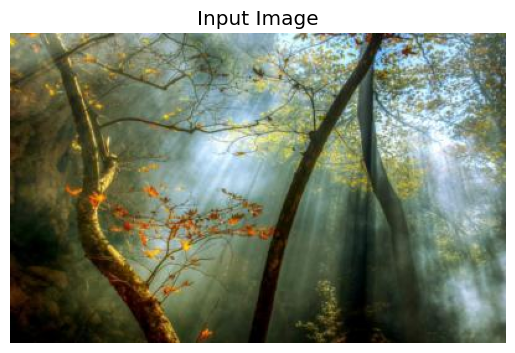

In [25]:
# Experiment #2 code

import torch
from torchvision import models, transforms
from PIL import Image
import requests
import json
import matplotlib.pyplot as plt

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load an image and apply transformations
def process_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t, img  # Return both the tensor and the original image

# Function to get predictions and print human-readable labels
def get_predictions(image_path, class_index_dict):
    tensor, original_img = process_image(image_path)
    with torch.no_grad():
        out = model(tensor)
    probabilities = torch.nn.functional.softmax(out, dim=1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    # Print the top 5 human-readable labels with their probabilities
    for i in range(top5_prob.size(1)):
        class_id = str(top5_catid[0][i].item())
        class_name = class_index_dict[class_id][1]  # Access the human-readable class name
        print(f"{class_name}: {top5_prob[0][i].item():.4f}")

    # Visualize the image
    plt.imshow(original_img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title("Input Image")
    plt.show()

# Download and load the ImageNet class index JSON
url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
response = requests.get(url)
response.raise_for_status()
imagenet_classes = json.loads(response.text)

# Example usage
image_path = get_image_files(path/'bird_or_not/forest')[random.randint(0,100)]
get_predictions(image_path, imagenet_classes)


lorikeet: 0.6032
macaw: 0.3912
goldfinch: 0.0044
bee_eater: 0.0007
toucan: 0.0002


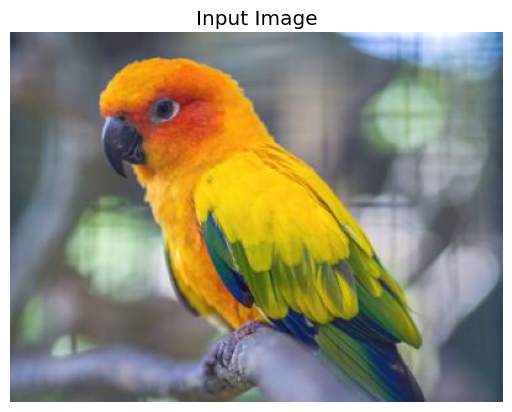

In [26]:
image_path = get_image_files(path/'bird_or_not/bird')[random.randint(0, 100)]
get_predictions(image_path, imagenet_classes)

dough: 0.1869
conch: 0.1604
mortar: 0.0811
spaghetti_squash: 0.0787
wooden_spoon: 0.0525


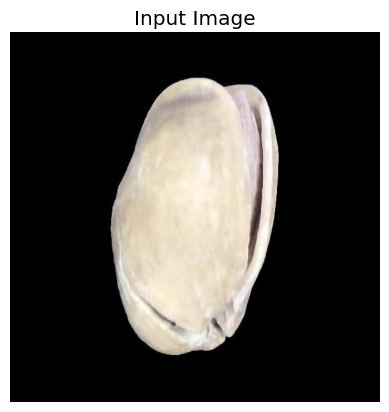

In [27]:
image_path = get_image_files(path/'pistachio/Kirmizi_Pistachio')[random.randint(0, 100)]
get_predictions(image_path, imagenet_classes)

Experiment #2 - Observations
1. Resnet18 wasn't able to predict the pistachio and forest images as well as it predicted the bird.
2. This indicates that the model was overfitting and needs more training data. Which is what was observed in Experiment #1 through fine tuning.

## Experiment #3 - Benchmark accuracy before/after fine-tuning

fast.ai provides a way to run the entire validation set through the model, and you can print the error rate.

Look at the bird classification error before and after fine-tuning. The original resnet18 model had an output layer with 1000 neurons (one for each image category). When we are fine-tuning, we are removing the output layer, and adding a new output layer that only has 2 neurons.

What is the error rate before and after fine-tuning? Why is the error rate so high initially?

In [ ]:
# Experiment #3 code


## Experiment #4 - Visualize model internals

Image-based models like resnet18 are based on convolution. It is common and sometimes interesting to visualize the various layers. Sometimes, because sometimes it gives people intuition for what's happening inside the model. Sometimes not, because another fact about deep learning is that its ways are mysterious, and we're not sure why models work so well.

Visualize a selection of the layers, especially the layers close to the beginning and close to the end.

In [ ]:
# Experiment #4 code


## Experiment #5 - Decrease training set size

Decrease the training set size, and plot error rates as a function of number of training images.

Create a large test set (different from your training and validation set). How does the model accuracy for the test set change based on different training set sizes?

In [ ]:
# Experiment #5 code


## Experiment #6 - Choose your own experiment

Next week (Week 2), we will do lightning presentations of different experiments. Go back to one of the previous experiments and further expand it, or explore one of the optional experiments below, or investigate an entirely different thing.

Presentations will be between 1-5 minutes (depending on the complexity of your experiment).

The goal is to continue to build our practical intuition, and to leverage the learnings that we'll get hearing what everyone else explored, and what they found out!

In [ ]:
# Experiment #6 code


## Experiment #7 (optional) - Increase number of epochs

Increase the number of epochs.

Create a large test set, can be the same as the prior experiment (different from your training and validation set). How does the model accuracy for the test set change based on different epochs? At what point do you see overfitting?

Decrease the training set size, does that make overfitting happen earlier?

In [ ]:
# Experiment #7 code


## Experiment #8 (optional) - Introduce bad training data

We'll find in this class that quality of training data is one of the biggest factors of model performance, and should be a big focus.

Explore the impact of mislabeling training images, and see when it starts to impact model accuracy.

In [ ]:
# Experiment #8 code


## Experiment #9 - (optional) Classify out-of-distribution images

Try passing in an image of a person, how does your fine-tuned model classify that image?

Try different techniques to better handle out-of-distribution images.

In [ ]:
# Experiment #9 code


## Experiment #10 - (optional) Compare different architectures

Try working with resnet34. How does this larger model perform with the different training set sizes?

In [ ]:
# Experiment #10 code
